# Прогнозирование температуры звезды

**Заказчик:** 

Обсерватория «Небо на ладони».
    
**Постановка задачи:** 

Разработка метода определения температуры на поверхности обнаруженных звёзд с использованием нейросетевого подхода.
    
**Описание задачи:** 

Необходимо создать модель нейронной сети, способную определять температуру на поверхности обнаруженных звёзд на основе доступных данных. Для этого требуется подготовить набор данных, содержащий информацию о различных характеристиках звёзд и соответствующие им измеренные значения температуры. Затем следует обучить нейросеть на этом наборе данных, чтобы она могла выявить закономерности и установить связь между входными параметрами и целевыми значениями температуры.    

**Оценка результата:** 

В данной задаче мы можем использовать метрику RMSE (Root Mean Square Error) для оценки качества модели. Цель состоит в том, чтобы минимизировать значение RMSE и добиться, чтобы оно не превышало 4500. RMSE представляет собой квадратный корень из среднеквадратичной ошибки между прогнозируемыми и фактическими значениями температуры.
    
**Описание данных:**
    
В базе обсерватории есть данные о 240 звёзд:
    
- `Luminosity(L/Lo)` - Относительная светимость — светимость звезды относительно Солнца.
- `Radius(R/Ro)` - Относительный радиус — радиус звезды относительно радиуса Солнца.
- `Absolute magnitude(Mv)` — Абсолютная звёздная величина — физическая величина, характеризующая блеск звезды.
- `Star color` — Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- `Star type` — Тип звезды:
    
<table>
    <tr>
        <th>Тип звезды</th>
        <th>Номер, соответствующий типу</th>
    </tr>
    <tr>
        <td>Коричневый карлик</td>
        <td>0</td>
    </tr>
    <tr>
        <td>Красный карлик</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Белый карлик</td>
        <td>2</td>
    </tr>
    <tr>
        <td>Звёзды главной последовательности</td>
        <td>3</td>
    </tr>
    <tr>
        <td>Сверхгигант</td>
        <td>4</td>
    </tr>
    <tr>
        <td>Гипергигант</td>
        <td>5</td>
    </tr>
</table>

____________________

**Целевой признак:** 
- `Temperature (K)` - Абсолютная температура — температура на поверхности звезды в Кельвинах.

##  **Задачи исследования**

- ### Этап 1: Разведочный анализ данных (EDA):
    - 1.1 Загрузка данных;
    - 1.2 Предобработка и исследовательский анализ данных;
    - 1.3 Анализ категориальные признаков;
    - 1.4 Обработка категориальных признаков;
    - 1.5 Анализ числовых признаков;
    - 1.6 Корреляции между числовыми признаками.
- ### Этап 2: Подготовка данных к построению модели:
    - 2.1 Выделение обучающей и тестовой выборок;
    - 2.2 Нормализация входных данных;
    - 2.3 Создание тензеров.
- ### Этап 3: Построение простой модели нейронной сети — baseline:
    - 3.1 Обучение baseline-модели.
- ### Этап 4: Улучшение нейронной сети;
- ### Этап 5: Проверка модели на тестовой выборке;
- ### Общий вывод.

    
    
    

## Этап 1: Разведочный анализ данных (EDA)

Подключение библиотек

In [ ]:
# !pip install -q torch seaborn phik skorch optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from math import sqrt

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from skorch import NeuralNetRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

# константы
RANDOM_SEED = 42

# настройки блокнота
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### 1.1 Загрузка данных

In [2]:
# загрузка данных:
try:
    df = pd.read_csv('./6_class.csv')
except:
    df = pd.read_csv('/datasets/6_class.csv')

### 1.2 Предобработка и исследовательский анализ данных

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


None

__Проверим пропуски в данных:__

In [4]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__    
- Данные загружены корректно.
- Пропуски в данных отсутствуют.
    
__Недостатки:__
- Некоректное названий стобцов, их следует переименовать;
- В датафрейме присутствует признак `Unnamed: 0`, наличие которого связано с импортом индексов датафрейма, при его сохранении, его следует удалить.
    
</div>

__Удаление признака__ `Unnamed: 0`

In [ ]:
df = df.drop('Unnamed: 0', axis=1).copy()

__Переименование признаков__

In [6]:
# создание словаря с новыми именами столбцов
new_column_names = {
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude_abs',
    'Star type': 'type',
    'Star color': 'color',
}
# переименование столбцов
df = df.rename(columns=new_column_names)

# вывод датасета с переименованными столбцами
display(df.head(2))

,Unnamed: 0,temperature,luminosity,radius,magnitude_abs,type,color
0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,3042,0.0005,0.1542,16.60,0,Red


__Дубликаты__

In [8]:
print(f'Количество дубликатов в данных:{df.duplicated().sum()}')

Количество дубликатов в данных:0


### 1.3 Анализ категориальные признаков

__Общая информация:__

In [9]:
display(df.describe(include=[object]))

,color
count,240
unique,19
top,Red
freq,112


In [10]:
df['type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

__Посмотрим уникальные значения в категориальных признаках:__

In [11]:
print(f'Уникальные значения признака color в данных:\n{df["color"].unique()}')

Уникальные значения признака color в данных:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
__Вывод:__ 
- Категориальный столбец `type` содержит равное количество записей для каждого типа звезд, что свидетельствует о том, что этот признак является репрезентативным.

    __Недостатки признака `color`:__
    - Встречаются записи одного и того же цвета, но в разных регистрах.
    - Также наблюдаются одинаковые записи цвета с использованием различных разделителей и пробелов.
</div>

### 1.4 Обработка категориальных признаков

In [12]:
# перевод записей в нижний регистр
df['color'] = df['color'].str.lower()
# стандартизация разделителей
df['color'] = df['color'].str.replace('-', ' ')
# удаление лишних пробельных символов
df['color'] = df['color'].str.strip()

In [13]:
df['color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

__Рассмотрим распределение количества записей в зависимости от значения признака `color`:__

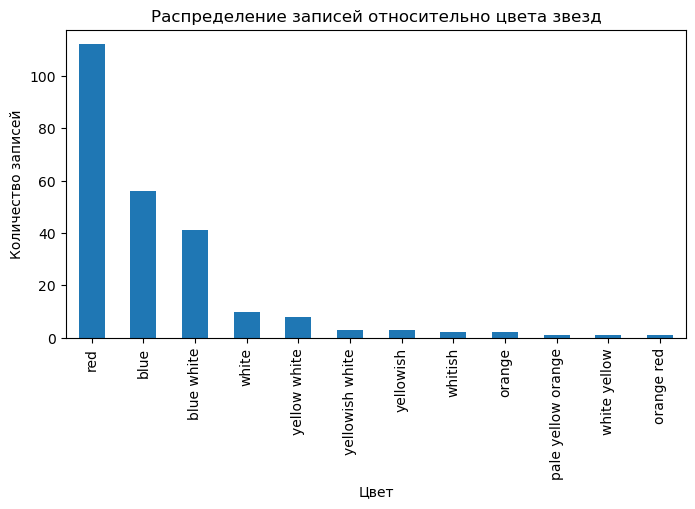

In [14]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
 
__Вывод:__
    
Исходя из графика, видно, что количество записей относительно разных цветов распределено неравномерно. Чтобы исправить это, предлагается объединить схожие записи цветов. В рамках этой коррекции, следующие группы цветов будут объединены:

- Желтый (yellow) будет включать:

     - Yellowish white
     - Yellow white
     - Yellowish
     - Pale yellow orange
    
- Белый (white) будет включать:

     - White
     - Whitish
     - White yellow
    
- Оранжевый (orange) будет включать:
    
     - Orange
     - Orange red
    
Такое объединение цветов основано на том, что в названии цветов более доминирующий цвет указывается слева относительно записи. Это позволит учесть близкие оттенки цветов и сгруппировать их в более общие категории для улучшения репрезентативности и удобочитаемости данных.
</div>

In [15]:
# создание словаря
replace_color = {
    'yellowish white': 'yellow',
    'yellow white': 'yellow',
    'yellowish': 'yellow',
    'pale yellow orange': 'yellow',
    'whitish': 'white',
    'white yellow': 'white',
    'orange red': 'orange',
}
# укрепление групп
df['color'] = df['color'].replace(replace_color).copy()

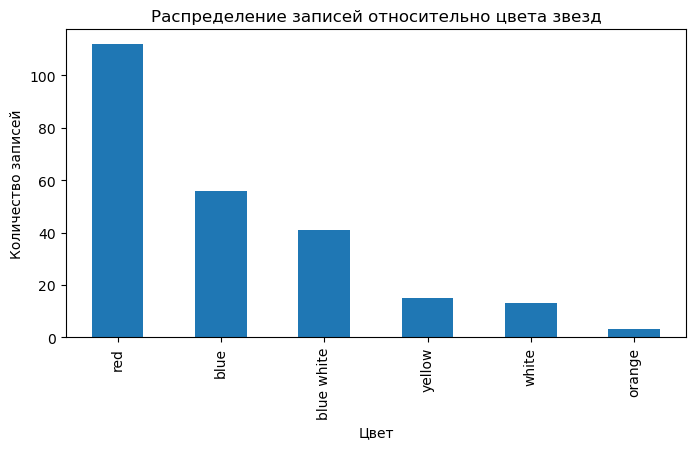

In [16]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Из графика видно, что распределение количества записей стало более сбалансированным после объединения схожих записей цветов. Однако все же остается небольшое количество записей с значением "orange" по сравнению с другими группами цветов. Это важное наблюдение, которое следует учесть при дальнейшем анализе данных.
</div>

### 1.5 Анализ числовых признаков

In [17]:
# общая информация
df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity,240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius,240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
magnitude_abs,240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06


- Данные имеют большое стандартное отклонение, что указывает на значительную вариативность.
- Явных аномалий в числовых данных нет.

__Посмотрим на распределения данных__

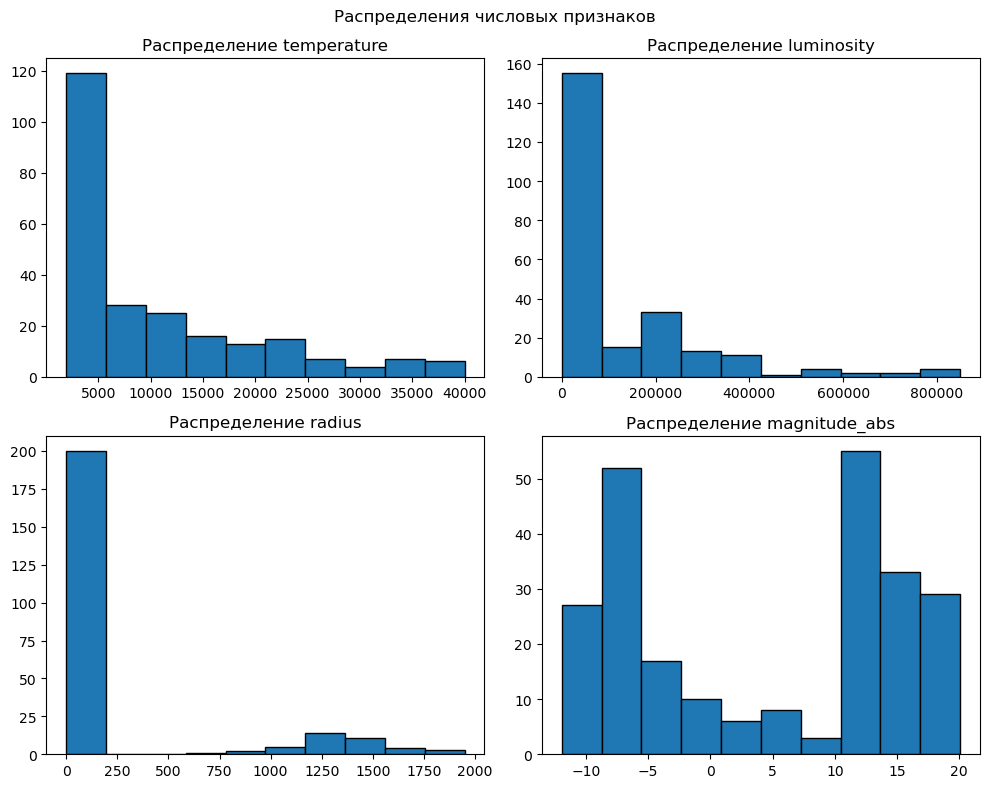

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
# гистограмма для 'temperature'
axes[0, 0].hist(df['temperature'], bins=10, edgecolor='black')
axes[0, 0].set_title('Распределение temperature')
# гистограмма для 'luminosity'
axes[0, 1].hist(df['luminosity'], bins=10, edgecolor='black')
axes[0, 1].set_title('Распределение luminosity')
# гистограмма для 'radius'
axes[1, 0].hist(df['radius'], bins=10, edgecolor='black')
axes[1, 0].set_title('Распределение radius')
# гистограмма для 'magnitude_abs'
axes[1, 1].hist(df['magnitude_abs'], bins=10, edgecolor='black')
axes[1, 1].set_title('Распределение magnitude_abs')

plt.suptitle('Распределения числовых признаков')

plt.tight_layout()
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__
    
- На графиках 'temperature', 'luminosity', 'radius' видно, что распределение ассимитрично вправо, что визуально подтверждает, табличные данные о большом значении стандартного отклонения.
- Так же стоит отметить схожесть графиков, что может быть признаком линейных зависимостей между этими признаками. Таким образом, светимость, возможно, достаточно точно отражает как и энергию звезды, так и ее радиус.
- Абсолютная звёздная величина, график magnitude_abs, имеет симметричное увеличение в обе стороны, что говорит о нисзком количестве схожиж звезд, по данному показателю, среди изученных
</div>

### 1.6 Корреляции между числовыми признаками

__Линейные взаимосвязи числовых данных__

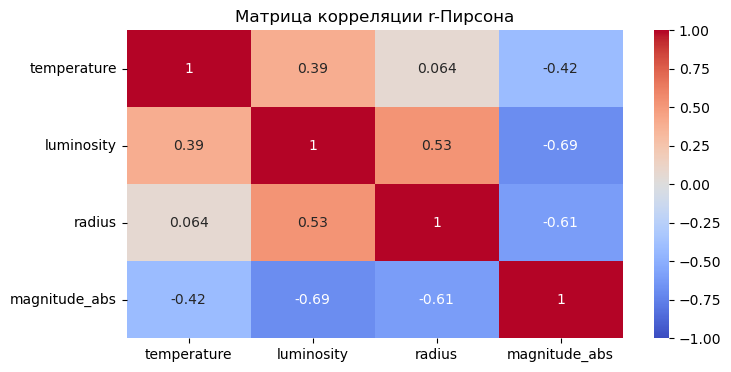

In [164]:
corr_matrix = df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].corr()
# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции r-Пирсона')

plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__

Предоставленные данные указывают на наличие линейных зависимостей между некоторыми признаками. В частности, обнаружены следующие линейные связи:

- Между температурой и светимостью: Коэффициент корреляции равен 0.39. Это указывает на положительную линейную зависимость между этими двумя признаками. При увеличении температуры возможно увеличение светимости, хотя сила и направление этой зависимости могут быть ограничены.

- Между светимостью и радиусом: Коэффициент корреляции равен 0.53. Это также указывает на положительную линейную зависимость между светимостью и радиусом. Большая светимость может быть связана с более большим радиусом звезды, хотя здесь также могут существовать другие факторы, влияющие на эту зависимость.

Учет этих линейных связей между признаками позволяет лучше понять физические свойства и характеристики звезд. Однако стоит отметить, что линейные связи не всегда являются единственными или полными моделями взаимосвязи между признаками, и возможно наличие иных более сложных взаимосвязей, которые следует учитывать в дальнейшем анализе.
</div>

In [20]:
phik_overview = df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'magnitude_abs']


,temperature,luminosity,radius,magnitude_abs
temperature,1.000000,0.561692,0.236090,0.709280
luminosity,0.561692,1.000000,0.574964,0.709456
radius,0.236090,0.574964,1.000000,0.512414
magnitude_abs,0.709280,0.709456,0.512414,1.000000


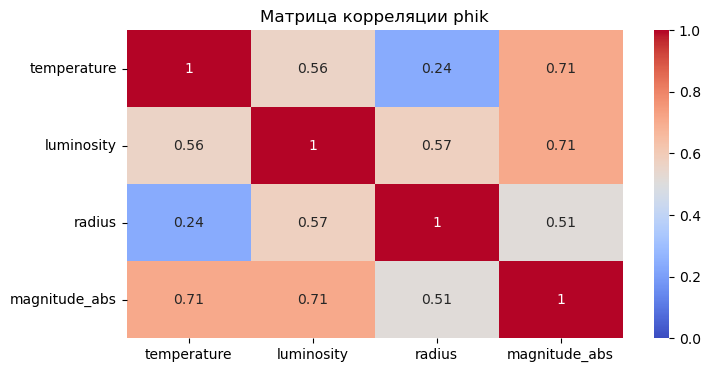

In [165]:
# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__

Согласно предоставленным данным, наблюдаются сильные нелинейные взаимосвязи между различными признаками, такими как температура, светимость, радиус и абсолютная величина звезд.

Присутствие таких нелинейных взаимосвязей подтверждает потенциал использования алгоритмов нейросетей для определения температуры на поверхности обнаруженных звезд. Нейронные сети могут эффективно обнаруживать и моделировать сложные нелинейные взаимосвязи в данных и строить предсказательные модели, которые учитывают эти взаимосвязи. Это позволяет получить более точные и надежные прогнозы температуры на основе других характеристик звезды.

Однако важно отметить, что выбор и конфигурация алгоритмов нейросетей требует тщательного исследования, обучения и оптимизации. Это поможет достичь наилучших результатов и гарантировать, что модель нейросети адекватно учитывает нелинейные взаимосвязи в данных для определения температуры на поверхности звезд.
</div>

## Этап 2: Подготовка данных к построению модели

- Разделение данных: Разделим данные на тренировочную и тестовую выборки. Поскольку у вас ограниченное количество наблюдений, оставить 20% данных для тестирования модели, а остальные 80% используем для обучения модели.
- Нормализация числовых данных: Произведем нормализацию числовых данных, чтобы все признаки имели сопоставимые диапазоны значений. Нормализация поможет стабилизировать обучение модели и предотвратить преимущественное влияние признаков с большими значениями.
- Преобразование категориальных данных в унитарный код: Категориальные данные, такие как цвет или тип звезды, необходимо преобразовать в унитарный код (one-hot encoding). Это позволит представить каждое категориальное значение в виде бинарного вектора, где каждый столбец соответствует определенной категории. Такое представление позволит модели учиться на категориальных данных.

### 2.1 Выделение обучающей и тестовой выборок

In [22]:
X = df.drop('temperature', axis=1)
y = df['temperature'] # целевой признак

In [23]:
# формирование выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [24]:
# проверка размерности выборок
for x in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'Размерность {x}: {globals()[x].shape} - {len(globals()[x])/len(df):.0%}')

Размерность X_train: (192, 5) - 80%
Размерность X_test: (48, 5) - 20%
Размерность y_train: (192,) - 80%
Размерность y_test: (48,) - 20%


### 2.2 Нормализация входных данных

In [25]:
# Определяем списки столбцов для разных типов данных
categorical_columns = ['type', 'color']                      # категориальные переменные
numeric_columns = ['luminosity', 'radius', 'magnitude_abs']  # числовые переменные

# Создаем объект ColumnTransformer для выполнения различных преобразований для указанных групп столбцов
col_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_columns),                     # StandardScaler масштабирует числовые данные
        ('ohe', OneHotEncoder(sparse_output=False), categorical_columns),  # OneHotEncoder преобразует категориальные данные в one-hot кодировку
    ],
    remainder='passthrough',  # оставшиеся столбцы, которые не участвуют в преобразовании, будут включены в выходные данные без изменений
    n_jobs=-1                 # использование всех процессоров для ускорения обработки
)

X_train = col_transformer.fit_transform(X_train)  # Обучение преобразователей и преобразование данных
X_test = col_transformer.transform(X_test)        # Применение обученных преобразований к новым данным

### 2.3 Создание тензеров

In [26]:
# преобразование выборок в тензоры
X_train_tensor = torch.Tensor(X_train)
X_test_tensor  = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train.values)
y_test_tensor  = torch.Tensor(y_test.values)

# проверка размерности тензоров
for x in ['X_train_tensor', 'X_test_tensor', 'y_train_tensor', 'y_test_tensor']:
    print(f'Размерность {x}: {globals()[x].shape}')

Размерность X_train_tensor: torch.Size([192, 15])
Размерность X_test_tensor: torch.Size([48, 15])
Размерность y_train_tensor: torch.Size([192])
Размерность y_test_tensor: torch.Size([48])


## Этап 3: Построение простой модели нейронной сети — baseline

__Архитектура нейронной сети:__

1 Входной слой:

   - Размерность входных данных определяется переменной input_size и равен количеству признаков.
   - Этот слой представлен в виде линейного слоя (nn.Linear), который принимает входные данные и производит линейную трансформацию с помощью весов и смещения.
   
2 Скрытые слои:

   - В данной архитектуре нейронной сети используем четыре скрытых слоя.
   - Каждый скрытый слой состоит из линейного слоя (nn.Linear), за которым следует функция активации.
   - Функции активации, используемые в этой архитектуре, определяются переменными activation_1, activation_2, activation_3, activation_4.
   - Добавление техники регуляризации Dropout, поможет улучшить обобщающую способность нейронной сети и снизит риск переобучения, вероятности выключения нейронов в слоях определяются переменными drop_1, drop_2, drop_3, drop_4. В baseline-модели данную технику применим только к первому слою, затем подберем опримальные параметры для этого и остальных слоев.
   - Размеры скрытого слоя определяются переменными hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4.
   
3 Выходной слой:

   - Выходной слой представлен линейным слоем (nn.Linear), который преобразует выходные значения скрытых слоев в одно число.
   - В данном случае, поскольку решается задача регрессии, выходной слой имеет размерность 1 и задается переменной output_size.
   
4 Инициализация весов:
   - Инициализацию весов будем производить с помощью метода Kaiming, что может помочь ускорить процесс обучения и предотвратить затухания/взрыва градиента.

In [ ]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
        """
        Базовая архитектура полносвязной нейронной сети с четырьмя скрытыми слоями и настраиваемыми параметрами.

        Параметры:
            input_size (int): Размер входного слоя.
            hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4 (int): Размеры скрытых слоев.
            output_size (int): Размер выходного слоя.
            drop_1, drop_2, drop_3, drop_4 (float): Вероятности дропаута для каждого скрытого слоя.
            activation_1, activation_2, activation_3, activation_4: Функции активации для каждого скрытого слоя.

        Методы:
            forward(x): Производит прямое распространение входного тензора через сеть.
            init_weights(m): Инициализирует веса слоев методом He initialization.
        """
        # Инициализация первого скрытого слоя с активацией и дропаутом
        self.fc1   = nn.Linear(input_size, hidden_size_1)
        self.act1  = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        # Инициализация второго скрытого слоя с активацией и дропаутом
        self.fc2   = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2  = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        # Инициализация третьего скрытого слоя с активацией и дропаутом
        self.fc3   = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3  = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        # Инициализация четвертого скрытого слоя с активацией и дропаутом
        self.fc4   = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4  = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        # Инициализация выходного слоя
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        # Инициализация весов сети
        self.apply(self.init_weights)
        
    def forward(self, x):
        """
        Определяет прямое распространение входного тензора через сеть.
        
        Параметры:
            x (torch.Tensor): Входной тензор.
        
        Возвращает:
            torch.Tensor: Выходной тензор сети.
        """
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(self, m):
        """
        Инициализирует веса модели с использованием метода "He initialization", также известного как "Kaiming initialization".
        
        Параметры:
            m (nn.Module): Слой для инициализации.
        """
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

- Для создания пакетов (batch) используем Dataloader, предоставляющий удобный способ загрузки и предварительной обработки данных во время обучения моделей машинного обучения. Данный компонент PyTorch позволяет настраивать различные параметры для загрузки данных, такие как размер пакета (batch size), количество рабочих процессов для параллельной загрузки данных (num_workers), случайное перемешивание данных (shuffle) 

In [143]:
class Batch(Dataset):
    """
    Класс для создания пакетов данных, наследуемый от Dataset. Предназначен для использования с DataLoader
    в PyTorch для эффективной загрузки и обработки данных во время обучения моделей.

    Параметры:
        data (list, numpy.array, torch.Tensor): Коллекция данных, которые нужно загрузить.
        labels (list, numpy.array, torch.Tensor): Соответствующие метки данных.

    Методы:
        __len__(): Возвращает количество элементов в датасете.
        __getitem__(idx): Извлекает и возвращает данные и метку для заданного индекса `idx` в формате словаря.
    """
    def __init__(self, data, labels):
        """
        Инициализация объекта Batch с данными и метками.
        
        Аргументы:
            data: Данные для обучения.
            labels: Метки для данных.
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        """
        Возвращает общее количество образцов в датасете.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Извлекает и возвращает пару "данные-метка" по индексу `idx`.

        Аргументы:
            idx (int): Индекс элемента для извлечения.

        Возвращает:
            dict: Словарь, содержащий данные и метку для указанного индекса.
        """
        label = self.labels[idx]
        data = self.data[idx]
        sample = {'data': data, 'temperature': label}
        return sample

In [144]:
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test  = Batch(X_test_tensor, y_test_tensor)

In [99]:
# параметры Baseline нейронной сети

# размер слоев
input_size = X_train_tensor.shape[1]
hidden_size_1 = 50
hidden_size_2 = 40
hidden_size_3 = 5
hidden_size_4 = 45
output_size = 1

# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.LeakyReLU()

# вероятности выключения нейронов в слое
drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.01  # скорость обучения
n_epochs = 1000       # количество эпох обучения
batch_size = 32       # размер пакета

In [145]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.MSELoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

__Ранняя остановка__

Чтобы не подбирать количество эпох и при этом избежать переобучения, воспользуемся ранней остановкой, для этого напишем класс для ее реализации.

In [146]:
class CustomEarlyStopping():
    """
    Класс для реализации ранней остановки обучения модели. Позволяет прекратить тренировку модели,
    если улучшение функции потерь не происходит в течение заданного количества эпох.

    Атрибуты:
        patience (int): Количество эпох без улучшения после которых происходит остановка тренировки.
        min_delta (float): Минимальное изменение функции потерь, которое считается улучшением.

    Методы:
        __call__(val_loss): Вызывает объект как функцию. Обновляет состояние ранней остановки в зависимости от новой функции потерь.
    """

    def __init__(self, patience=5, min_delta=0):
        """
        Инициализирует параметры для ранней остановки.
        
        Параметры:
            patience (int): Количество эпох, которое необходимо подождать после последнего улучшения, прежде чем остановить обучение.
            min_delta (float): Минимальное изменение функции потерь между эпохами, которое считается статистически значимым улучшением.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Обрабатывает новую значение функции потерь и обновляет состояние остановки обучения.

        Параметры:
            val_loss (float): Новое значение функции потерь после эпохи.

        Обновляет лучшее значение потерь или увеличивает счетчик эпох без улучшений.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True

__Функция для обучения__

In [147]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):
    """
    Функция для тренировки модели с механизмом ранней остановки.

    Параметры:
        model (torch.nn.Module): Обучаемая модель.
        train_dataloader (DataLoader): DataLoader для обучающего датасета.
        test_dataloader (DataLoader): DataLoader для тестового датасета.
        optimizer (torch.optim.Optimizer): Оптимизатор для обновления весов модели.
        loss (function): Функция потерь для оценки качества модели.
        n_epochs (int): Количество эпох обучения.
        patience (int): Количество эпох для активации ранней остановки после последнего улучшения.
        min_delta (float): Минимальное изменение функции потерь, которое считается улучшением.

    Возвращает:
        dict: Словарь с результатами обучения, включая историю RMSE для обучающего и тестового датасетов,
              эпоху наилучшего результата, эпоху остановки и модель с наилучшим результатом.
    """

    # Инициализация результатов обучения
    result = {'rmse_train': [], 'rmse_test': [], 'best_epoch': None, 'stopping_epoch': None, 'best_model': None}
    
    # Инициализация механизма ранней остановки
    early_stopping = CustomEarlyStopping(patience, min_delta)
    
    for epoch in range(n_epochs):
        # Этап обучения
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['temperature']
            
            optimizer.zero_grad()  # Очистка градиентов
            
            predictions = model.forward(data).flatten()
            loss_value = loss(predictions, label_train)
            total_loss += loss_value.item()
            
            loss_value.backward()  # Обратное распространение ошибки
            optimizer.step()       # Шаг оптимизации
        
        # Расчет RMSE для обучающего набора
        rmse_tr = sqrt(total_loss / len(train_dataloader))
        result['rmse_train'].append(rmse_tr)
        
        # Этап тестирования
        model.eval()
        total_loss = 0.0
        with torch.no_grad():  # Отключение вычисления градиентов для тестирования
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['temperature']
                
                predictions = model.forward(data).flatten()
                loss_value = loss(predictions, label_test)
                total_loss += loss_value.item()
            rmse_ts = sqrt(total_loss / len(test_dataloader))
            result['rmse_test'].append(rmse_ts)
            
        # Вывод результатов каждые 10 эпох или в последнюю эпоху
        if epoch % 10 == 0 or epoch == n_epochs - 1:    
             print(f'Epoch: {epoch} RMSE_train: {round(rmse_tr)} RMSE_test: {round(rmse_ts)}')
        
        # Вызов ранней остановки с проверкой условий
        early_stopping(rmse_ts)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch - patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch - patience} RMSE_train: {round(result['rmse_train'][-patience])} RMSE_test: {round(result['rmse_test'][-patience])}")
            break
        if epoch == n_epochs - 1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch} RMSE_train: {round(result['rmse_train'][-1])} RMSE_test: {round(result['rmse_test'][-1])}")
            
    return result

### 3.1 Обучение baseline-модели

In [103]:
# обучение и сохранение результатов
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 RMSE_train: 13898 RMSE_test: 8066
Epoch: 10 RMSE_train: 13159 RMSE_test: 7550
Epoch: 20 RMSE_train: 9331 RMSE_test: 5541
Epoch: 30 RMSE_train: 5994 RMSE_test: 3496
Epoch: 40 RMSE_train: 4686 RMSE_test: 3376
Epoch: 50 RMSE_train: 4502 RMSE_test: 3404
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 34 RMSE_train: 4822 RMSE_test: 3350


__График процесса обучения__

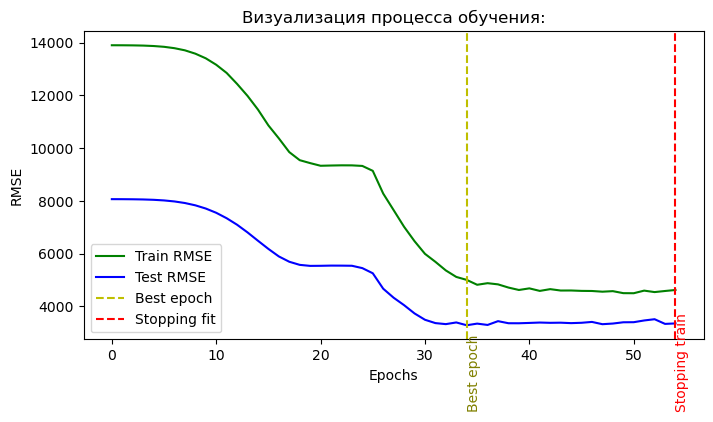

In [166]:
plt.figure(figsize=(8, 4))
plt.plot(result['rmse_train'], color='green', label='Train RMSE')
plt.plot(result['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')
plt.text(result['best_epoch'], 0.9, 'Best epoch', color='olive', rotation=90, va='bottom')
# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')
plt.text(result['stopping_epoch'], 0.9, 'Stopping train', color='red', rotation=90, va='bottom')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.show()

__График "Факт - Прогноз" baseline-модели:__

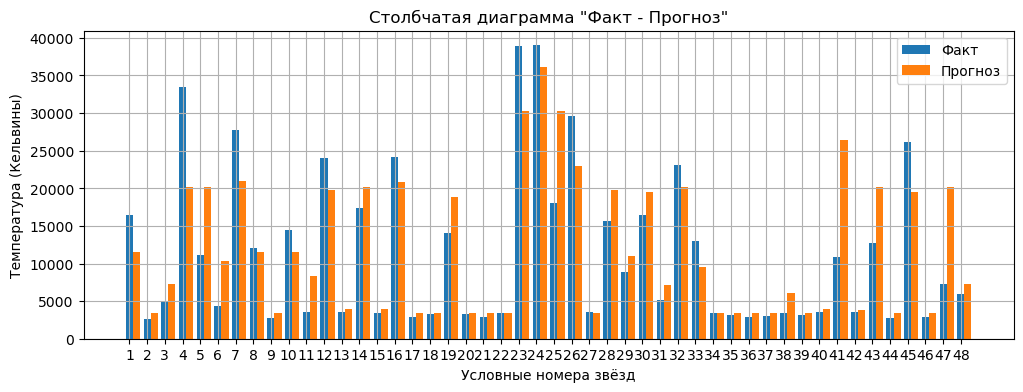

In [169]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = result['best_model'].forward(X_test_tensor).detach().numpy().flatten()
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(12, 4))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
__Вывод:__

- Уровень качества baseline-модели, предсказывающей температуру звезд, достаточно хорош, учитывая метрики RMSE на тренировочной и тестовой выборках(RMSE_train: 4822 RMSE_test: 3350). Однако, из графика "Факт - Прогноз" становится заметно, что модель имеет тенденцию предсказывать более усредненные значения температуры для наиболее горячих звезд.
- Такое поведение можно объяснить низким количеством записей в данных. Относительно недостаточное количество наблюдений для наиболее горячих звезд может затруднять адекватное обучение модели для точного предсказания их температуры.
- Для дальнейшего усовершенствования алгоритма, мы можем провести эксперименты с различными параметрами, такими как размер пакета обучения (batch size), вероятность выключения нейронов из обучения (dropout), функции активации в слоях и количество нейронов в слое. Это позволит настроить модель более оптимально для данной задачи и повысить точность предсказаний, даже при ограниченном количестве данных о звездах.
    
</div>

## Этап 4: Улучшение нейронной сети

- Для подбора оптимальных параметров используем __optuna__

In [135]:
# фукция для расчета RMSE
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

In [138]:
def objective(trial):
    """
    Функция для оптимизации гиперпараметров модели с использованием Optuna.

    Использует Skorch для оборачивания модели PyTorch в интерфейс, совместимый со Sklearn.
    Определяет и тестирует различные гиперпараметры, такие как размеры скрытых слоев,
    типы функций активации, вероятности дропаута, скорость обучения и размер пакета.

    Параметры:
        trial (optuna.trial.Trial): Объект trial от Optuna для предложения гиперпараметров.

    Возвращает:
        float: Среднее значение RMSE, полученное в результате кросс-валидации.
    """
    
    # Определение параметров дропаута
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # Словарь доступных функций активации
    activation_dict = {
        'nn.LeakyReLU()': nn.LeakyReLU(),
        'nn.ReLU()': nn.ReLU(),
        'nn.Tanh()': nn.Tanh(),
        'nn.ELU()': nn.ELU()
    }
    
    # Выбор функций активации
    activation_1 = trial.suggest_categorical('module__activation_1', list(activation_dict.keys()))
    activation_2 = trial.suggest_categorical('module__activation_2', list(activation_dict.keys()))
    activation_3 = trial.suggest_categorical('module__activation_3', list(activation_dict.keys()))
    activation_4 = trial.suggest_categorical('module__activation_4', list(activation_dict.keys()))
    
    activation_1 = activation_dict[activation_1]
    activation_2 = activation_dict[activation_2]
    activation_3 = activation_dict[activation_3]
    activation_4 = activation_dict[activation_4]

    # Определение размеров скрытых слоев
    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 60, step=1)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 60, step=1)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 60, step=1)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 60, step=1)

    # Скорость обучения и размер пакета
    lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-0)
    batch_size = trial.suggest_int('batch_size', 5, 120, step=10)
    
    # Создание модели
    model_base = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # Определение терпимости остановки
    patience = trial.suggest_int('patience', 10, 60, step=5)

    # Настройка регрессора Skorch
    skorch_regressor = NeuralNetRegressor(
        module=model_base,
        device='cpu',
        verbose=0,
        batch_size=batch_size,
        optimizer=torch.optim.Adam,
        max_epochs=2500,
        lr=lr,
        criterion=nn.MSELoss,
        callbacks=[
            ('val_rmse', EpochScoring(scoring='neg_root_mean_squared_error', lower_is_better=True, name='RMSE')),
            ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=patience))
        ]
    )

    # Кросс-валидация модели
    rmse = cross_val_score(skorch_regressor, X_train_tensor.numpy().astype('float32'),
                           y_train_tensor.numpy().astype('float32').reshape(-1,1),
                           n_jobs=-1, cv=4, scoring='neg_root_mean_squared_error')
    rmse = -rmse.mean()  # Преобразуем RMSE обратно в положительное значение
    return rmse

In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

__Результаты подбора параметров:__

In [140]:
print(f'Лучшее значение RMSE: {round(study.best_trial.values[0])}')

Лучшее значение RMSE: 4043


In [160]:
best_params = study.best_trial.params
display('Оптимальные параметры:', best_params)

'Оптимальные параметры:'

{'module__drop_1': 0.30000000000000004,
 'module__drop_2': 0.0,
 'module__drop_3': 0.0,
 'module__drop_4': 0.1,
 'module__activation_1': 'nn.Tanh()',
 'module__activation_2': 'nn.Tanh()',
 'module__activation_3': 'nn.ELU()',
 'module__activation_4': 'nn.LeakyReLU()',
 'module__hidden_size_1': 38,
 'module__hidden_size_2': 42,
 'module__hidden_size_3': 27,
 'module__hidden_size_4': 22,
 'learning_rate': 0.009978299951651445,
 'batch_size': 115,
 'patience': 35}

## Этап 5: Проверка модели на тестовой выборке

In [148]:
# инициализация оптимальных параметров
activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

input_size = X_train.shape[-1]
output_size = 1

hidden_size_1 = best_params['module__hidden_size_1']
hidden_size_2 = best_params['module__hidden_size_2']
hidden_size_3 = best_params['module__hidden_size_3']
hidden_size_4 = best_params['module__hidden_size_4']

drop_1 = round(best_params['module__drop_1'], 1)
drop_2 = round(best_params['module__drop_2'], 1)
drop_3 = round(best_params['module__drop_3'], 1)
drop_4 = round(best_params['module__drop_4'], 1)

activation_1 = best_params['module__activation_1']
activation_2 = best_params['module__activation_2']
activation_3 = best_params['module__activation_3']
activation_4 = best_params['module__activation_4']

activation_1 = activation_dict.get(activation_1)
activation_2 = activation_dict.get(activation_2)
activation_3 = activation_dict.get(activation_3)
activation_4 = activation_dict.get(activation_4)

learning_rate = best_params['learning_rate']

batch_size = best_params['batch_size']

patience = best_params['patience']

n_epochs = 1000

In [149]:
# экземпляр нейронной сети
model_test = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                      drop_1, drop_2, drop_3, drop_4,
                      activation_1, activation_2, activation_3, activation_4)

# функция потерь
loss = nn.MSELoss()

# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [150]:
# обучение и сохранение результатов
result_test = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=patience,
               min_delta=0)

Epoch: 0 RMSE_train: 13814 RMSE_test: 10785
Epoch: 10 RMSE_train: 13860 RMSE_test: 10764
Epoch: 20 RMSE_train: 13065 RMSE_test: 10093
Epoch: 30 RMSE_train: 8915 RMSE_test: 6885
Epoch: 40 RMSE_train: 7897 RMSE_test: 6130
Epoch: 50 RMSE_train: 7426 RMSE_test: 5831
Epoch: 60 RMSE_train: 7122 RMSE_test: 5612
Epoch: 70 RMSE_train: 6108 RMSE_test: 4777
Epoch: 80 RMSE_train: 4829 RMSE_test: 4168
Epoch: 90 RMSE_train: 4474 RMSE_test: 3813
Epoch: 100 RMSE_train: 4057 RMSE_test: 3350
Epoch: 110 RMSE_train: 3782 RMSE_test: 3188
Epoch: 120 RMSE_train: 3639 RMSE_test: 3161
Epoch: 130 RMSE_train: 3605 RMSE_test: 3215
Epoch: 140 RMSE_train: 3453 RMSE_test: 3191
Epoch: 150 RMSE_train: 3675 RMSE_test: 3235
INFO: Ранняя остановка. Счетчик: 35/35
Best epoch: 115 RMSE_train: 3620 RMSE_test: 3145


__График процесса обучения__

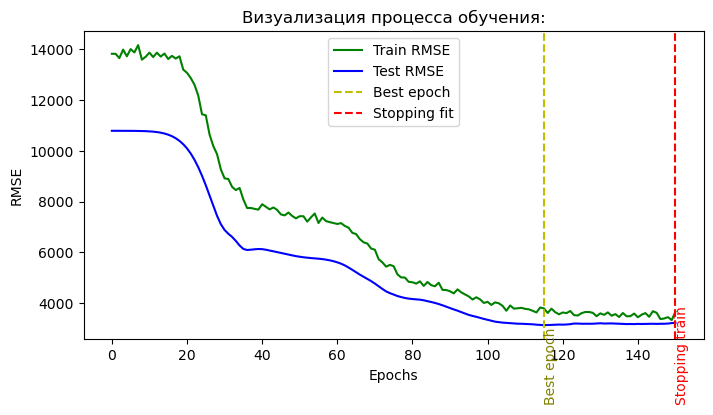

In [170]:
plt.figure(figsize=(8, 4))
plt.plot(result_test['rmse_train'], color='green', label='Train RMSE')
plt.plot(result_test['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result_test['best_epoch'], color='y', linestyle='--', label='Best epoch')
plt.text(result_test['best_epoch'], 0.9, 'Best epoch', color='olive', rotation=90, va='bottom')
# отметка Stopping train
plt.axvline(x=result_test['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')
plt.text(result_test['stopping_epoch'], 0.9, 'Stopping train', color='red', rotation=90, va='bottom')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper center')
plt.show()

__График "Факт - Прогноз" нейросити с оптимальными параметрами:__

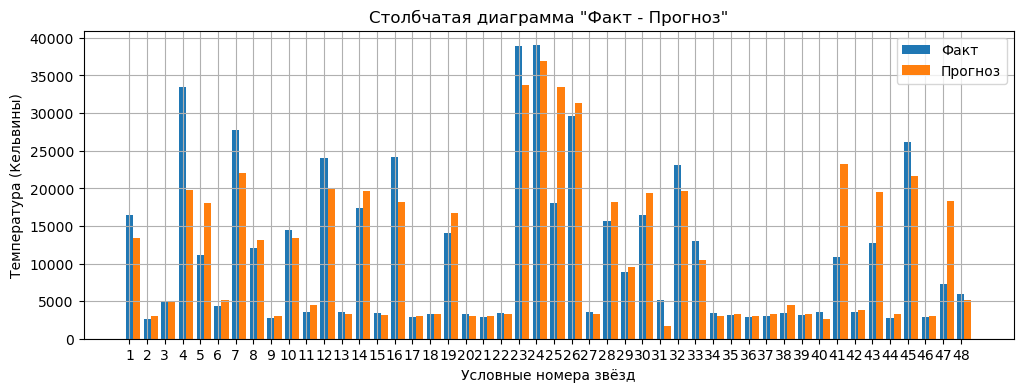

In [176]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = result_test['best_model'].forward(X_test_tensor).detach().numpy().flatten()
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(12, 4))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__
    
- После подбора параметров, удалось достичь заметного улучшения её качества по сравнению с базовой моделью. Значения метрик RMSE_train и RMSE_test стали меньше, что свидетельствует о более точном предсказании температуры звезд.
- Модель продемонстрировала хорошую обобщающую способность на тестовых данных, что подтверждается небольшой разницей между RMSE_train и RMSE_test. Это говорит о том, что модель не переобучилась на тренировочных данных и способна эффективно обрабатывать новые наблюдения.
- Оптимизация параметров модели позволила устранить тенденцию к предсказанию более усредненных значений температуры для наиболее горячих звезд, которую мы наблюдали в базовой модели, что можно увидеть на графике "Факт - Прогноз". Это может быть связано с оптимальным выбором функций активации, количеством нейронов в слоях и вероятностью отключения нейронов из обучения.
    
</div>

__Сводная таблица метрик нейронных сетей:__

In [163]:
data = {
    'Model': ['Baseline', 'Best Model'],
    'RMSE_train': [4822, 3620],
    'RMSE_test': [3350, 3145],
    'Best_epoch': [34, 115]
}
display(pd.DataFrame(data))

,Model,RMSE_train,RMSE_test,Best_epoch
0,Baseline,4822,3350,34
1,Best Model,3620,3145,115


## Общий вывод

- Обучив Baseline-модель, были получены следующие результаты: RMSE_train: 4822, RMSE_test: 3350. Модель демонстрировала способность предсказывать температуру звезд, но на графике "Факт - Прогноз" была заметна тенденция предсказывать более усредненные значения для наиболее горячих звезд.
- Для улучшения качества предсказания, мы приступили к разработке второй модели и использовали библиотеку Optuna для автоматического подбора оптимальных параметров. Были оптимизированы следующие параметры модели:

     - Размер пакета обучения (batch size): Оптимальный размер пакета составил 115, что позволило ускорить обучение модели и обновлять веса чаще, улучшая стабильность и скорость сходимости.

     - Dropout: Метод Dropout позволяет уменьшить взаимозависимость между нейронами, что делает модель более устойчивой к шуму и способной лучше обобщать на новые данные. Оптимальные значения Dropout были установлены как 0.3, 0.0, 0.0 и 0.1 для каждого слоя соответственно.

     - Функции активации: Вторая модель использовала различные функции активации для разных слоев, такие как Tanh, ELU и LeakyReLU. Это позволило модели выучивать более разнообразные представления данных.

     - Размеры скрытых слоев: Оптимальные размеры скрытых слоев были установлены равными 38, 42, 27 и 22 соответственно.
     
- После проведения оптимизации параметров, вторая модель показала следующие результаты: RMSE_train: 3620, RMSE_test: 3145. Модель продемонстрировала более высокую обобщающую способность, чем первая модель, и имееет более низкие значения метрик качества на обучающей и тестовой выборках.
- Дальнейшие улучшения могут быть достигнуты путем сбора дополнительных данных, оптимизации других параметров обучения, исследования различных архитектур сетей и использования ансамблей моделей для улучшения предсказательной способности.